### Taget: Using python and numpy implement a neural network framework
> Node:
+ forward: *Function*, how to caculate the inputs
+ backwards: *Function*, how to get the gradients when backpropogation
+ gradients: *Mapper*, the gradients this node to its inputs node
+ inputs: *List*, the input nodes of this node
+ outputs: *List*, the output node of this node

In [1]:
class Node:
    """
    Each node in neural networks will have these attributes and methods
    """
    def __init__(self, inputs=[]):
        """
        if the node is the operator of "ax + b", the inputs will be x node , and the outputs 
        of this is its successors. 
        
        and the value is *ax + b*
        """
        self.inputs = inputs # input_list <- C, Java <- 匈牙利命名法 -> Python 特别不建议
       # self.outputs = outputs # output_list 
        self.value = None 
        self.outputs = []
        self.gradients = {}
        
        for node in self.inputs:
            node.outputs.append(self) # build a connection relationship
    
    def forward(self):
        """Forward propogation
        
        compute the output value based on input nodes and store the value 
        into *self.value*
        """
        raise NotImplemented
    
    def backward(self):
        """ Back propogation
        
        compute the gradient of each input node and store the value 
        into "self.gredients"
        """
        raise NotImplemented

In [2]:
def Input(Node):
    def __init__(self, name = ''):
        self.name = name
        Node.__init__(self, inputs=[])
        
    def forward(self, value = None):
        if value is not None:
            self.value = value
    
    def backward(self):
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost
            
    def __repr__(self):
        return 'Input Node: {}'.format(self.name)

In [3]:
class Input(Node):
    def __init__(self, name=''):
        Node.__init__(self, inputs=[])
        self.name= name
    
    def forward(self, value=None):
        if value is not None:
            self.value = value
        
    def backward(self):
        self.gradients = {}
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost
    
    def __repr__(self):
        return 'Input Node: {}'.format(self.name)

In [4]:
class Linear(Node):
    def __init__(self, nodes, weights, bias):
        self.w_node = weights
        self.x_node = nodes
        self.b_node = bias
        Node.__init__(self, inputs=[nodes, weights, bias])
    
    def forward(self): 
        """compute the wx + b using numpy"""
        self.value = np.dot(self.x_node.value, self.w_node.value) + self.b_node.value
        
    
    def backward(self):
        
        for node in self.outputs:
            #gradient_of_loss_of_this_output_node = node.gradient[self]
            grad_cost = node.gradients[self]
            self.gradients[self.w_node] = np.dot(self.x_node.value.T, grad_cost)
            self.gradients[self.x_node] = np.dot(grad_cost, self.w_node.value.T)
            self.gradients[self.b_node] = np.sum(grad_cost * 1, axis = 0, keepdims=False)

In [5]:
class Sigmoid(Node):
    def __init__(self, node):
        self.x_node = node
        Node.__init__(self, inputs=[node])
        
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-1 * x))
        
    def forward(self):
        self.value = self._sigmoid(self.x_node.value)
    
    def backward(self):
        y = self.value
        self.partial = y * (1- y)
        
        for node in self.outputs:
            grad_cost = node.gradients[self]
            self.gradients[self.x_node] = grad_cost * self.partial

In [6]:
class MSE(Node):
    def __init__(self, y_true, y_hat):
        self.y_true_node = y_true
        self.y_hat_node = y_hat
        Node.__init__(self, inputs=[y_true, y_hat])
        
    def forward(self):
        y_true_flatten = self.y_true_node.value.reshape(-1,1)
        y_hat_flatten = self.y_hat_node.value.reshape(-1,1)
        self.diff = y_true_flatten - y_hat_flatten
        self.value = np.mean(self.diff ** 2)
        
    def backward(self):
        n = self.y_hat_node.value.shape[0]
        
        self.gradients[self.y_true_node] = (2 / n) * self.diff
        self.gradients[self.y_hat_node] = (-2 / n) * self.diff

In [7]:
def training_one_batch(topological_sorted_graph):
    ## graph 是经过拓扑排序之后的一个list
    for node in topological_sorted_graph:
        node.forward()
    for node in topological_sorted_graph[::-1]:
        node.backward()

In [8]:
def topological_sort(data_with_value):
    feed_dict = data_with_value
    input_nodes = [n for n in feed_dict.keys()]
    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in':set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in':set(), 'out':set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)   
    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()
        
        if isinstance(n, Input):
            n.value = feed_dict[n]
        ## if n is input node, set n'value as 
        ## feed_dict[n]
        ## else, n's value is caculate as its
        ## inbounds
        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            ## if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    
    return L

In [9]:
def sgd_update(trainable_nodes, learning_rate=1e-2):
    for t in trainable_nodes:
        t.value += -1 * learning_rate * t.gradients[t]

#### Preprocessing data

In [10]:
from sklearn.datasets import load_boston
import numpy as np
data = load_boston()
X_ = data['data']
y_ = data['target']

In [11]:
X_ = (X_ - np.mean(X_, axis = 0)) / np.std(X_, axis=0)

In [12]:
n_features = X_.shape[1]
n_hidden = 10
n_hidden_2 = 1

In [13]:
W1_, b1_ = np.random.randn(n_features, n_hidden), np.zeros(n_hidden)
W2_, b2_ = np.random.randn(n_hidden, n_hidden_2), np.zeros(n_hidden_2)
# W3_, b3_ = np.random.randn(n_hidden_2, 1), np.zeros(1)

#### Build a graph connection

##### 1st Build Nodes in this graph

In [14]:
X, y = Input(name='X'), Input(name='Y')
W1, b1 = Input(name='W1'), Input(name='b1')
W2, b2 = Input(name='W2'), Input(name='b2')
# W3, b3 = Input(name='W3'), Input(name='b3')

##### 2nd build connection relationship

In [15]:
linear_output = Linear(X, W1, b1)
sigmoid_output = Sigmoid(linear_output)
y_hat = Linear(sigmoid_output, W2, b2)
loss = MSE(y, y_hat)

In [16]:
input_node_with_value = {   # -> feed_dict
    X:X_,
    y:y_,
    W1:W1_,
    b1:b1_,
    W2:W2_,
    b2:b2_
}

In [17]:
graph = topological_sort(input_node_with_value)

In [18]:
graph

[Input Node: X,
 Input Node: Y,
 Input Node: W2,
 Input Node: b1,
 Input Node: b2,
 Input Node: W1,

In [19]:
from sklearn.utils import resample

In [20]:
np.random.choice(range(100), size=10, replace=True)

array([38,  3, 82, 63, 80, 54, 86, 94, 47, 34])

In [21]:
def run(dictionary):
    return topological_sort(dictionary)

In [22]:
losses = []
epochs = 5000
batch_size = 64
steps_per_epoch = 1
# steps_per_epoch = X_.shape[0] // batch_size

for i in range(epochs):
    loss = 0
    
    for batch in range(steps_per_epoch):
        x_batch, y_batch = resample(X_, y_, n_samples=batch_size)
        X.value = x_batch
        y.value = y_batch
        
        training_one_batch(graph)
        learning_rate = 1e-3
        sgd_update(trainable_nodes=[W1, W2, b1, b2], learning_rate=learning_rate)
        loss += graph[-1].value
    if i % 100 == 0:
        print('Epoch: {}, loss = {:.3f}'.format(i + 1, loss/steps_per_epoch))
        losses.append(loss)

Epoch: 1, loss = 646.973
Epoch: 101, loss = 162.530
Epoch: 201, loss = 49.931
Epoch: 301, loss = 66.072
Epoch: 401, loss = 32.288
Epoch: 501, loss = 44.344
Epoch: 601, loss = 50.287
Epoch: 701, loss = 28.035
Epoch: 801, loss = 19.258
Epoch: 901, loss = 43.351
Epoch: 1001, loss = 14.426
Epoch: 1101, loss = 22.545
Epoch: 1201, loss = 55.329
Epoch: 1301, loss = 22.338
Epoch: 1401, loss = 18.486
Epoch: 1501, loss = 19.997
Epoch: 1601, loss = 21.690
Epoch: 1701, loss = 24.463
Epoch: 1801, loss = 16.487
Epoch: 1901, loss = 13.477
Epoch: 2001, loss = 13.517
Epoch: 2101, loss = 16.655
Epoch: 2201, loss = 19.902
Epoch: 2301, loss = 24.429
Epoch: 2401, loss = 19.517
Epoch: 2501, loss = 26.161
Epoch: 2601, loss = 13.059
Epoch: 2701, loss = 22.220
Epoch: 2801, loss = 20.188
Epoch: 2901, loss = 14.456
Epoch: 3001, loss = 16.801
Epoch: 3101, loss = 13.823
Epoch: 3201, loss = 8.340
Epoch: 3301, loss = 12.225
Epoch: 3401, loss = 19.644
Epoch: 3501, loss = 14.673
Epoch: 3601, loss = 8.181
Epoch: 3701, 

In [23]:
import matplotlib.pyplot as plt

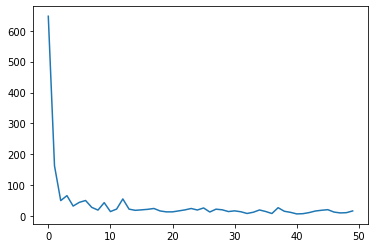

In [24]:
plt.plot(losses)